# **Detección de anomalías en el dataset *Elliptic***

> Algoritmos de detección de anomalías para grafos aplicados al dataset de transacciones de Bitcoin *Elliptic*

> Víctor Pérez Cano (victor.perezcano@estudiante.uam.es)

---

## Preparación

In [1]:
#@title #### Instalación de *torch geometric*
import torch

!pip install torch_geometric

# Optional dependencies:
if torch.cuda.is_available():
    !pip install pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.2.0+cu121.html
else:
    !pip install pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.2.0+cpu.html


KeyboardInterrupt: 

In [ ]:
#@title #### Instalación de *PyGOD*

!pip install pygod

In [ ]:
#@title #### Montar unidad de Google Drive
from google.colab import drive

drive.mount('/content/gdrive',force_remount=True)
%cd '/content/gdrive/My Drive/Colab Notebooks/TFG Infor'

In [ ]:
#@title Instalación de otras librerías

!pip install matplotlib
!pip install scikit-learn

import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics.cluster import contingency_matrix

---
---
# Pruebas

## Carga del dataset *Elliptic* (atemporal)

Inicialmente se omitirá la componente temporal y se realizará la detección de anomalías sobre el conjunto del grafo, es decir, en todos los *time steps* (del 1 al 49).

In [ ]:
from torch_geometric.data import Data
from torch_geometric.datasets import EllipticBitcoinDataset

In [ ]:

dataset = EllipticBitcoinDataset('./Datasets/Elliptic_GAD/Atemporal')
data = dataset.get(0)
data

Data(x=[203769, 165], edge_index=[2, 234355], y=[203769], train_mask=[203769], test_mask=[203769])

In [ ]:
class_idxs, counts = torch.unique(data.y, return_counts=True)
class_mappings = {
    0: 'Licit',
    1: 'Illicit',
    2: 'Unknown'
}

# Imprimir los valores únicos y sus conteos
for class_idx, count in zip(class_idxs, counts):
    print(f"Clase: {class_idx} ({class_mappings[int(class_idx)]}).\tCantidad: {count}")

Clase: 0 (Licit).	Cantidad: 42019
Clase: 1 (Illicit).	Cantidad: 4545
Clase: 2 (Unknown).	Cantidad: 157205


In [ ]:
labeled_mask = data.train_mask | data.test_mask
torch.sum(labeled_mask).item()

46564

Podemos observar que los datos que se usan tanto para el entrenamiento como para los tests en caso de un aprendizaje supervisado, constituyen el conjunto de datos etiquetados del dataset: 46564 = 42019 + 4545

## ***Graph Autoencoder (GAE)***

In [ ]:
from pygod.detector import GAE

gae = GAE(hid_dim=64,
          dropout=0.2,
          contamination=0.08,
          recon_s=True,
          epoch=10,
          lr=0.001,
          verbose=2
          )

In [ ]:

gae.fit(data)

In [ ]:
pred, score, prob, conf = gae.predict(return_pred=True,
                                      return_score=True,
                                      return_prob=True,
                                      return_conf=True
                                      )
print('Labels:', pred)
print('Raw scores:', score)
print('Probability:', prob)
print('Confidence:', conf)

Test: Loss 0.0000 | 


## Carga del dataset *Elliptic* (para el *time step* t=1)



In [ ]:
from torch_geometric.datasets import EllipticBitcoinTemporalDataset

data = EllipticBitcoinTemporalDataset('./Datasets/Elliptic_GAD/Temporal/1', 1).get(0)
data

Data(x=[7880, 165], edge_index=[2, 9164], y=[7880], train_mask=[7880], test_mask=[7880])

In [ ]:
class_idxs, counts = torch.unique(data.y, return_counts=True)
class_mappings = {
    0: 'Licit',
    1: 'Illicit',
    2: 'Unknown'
}

# Imprimir los valores únicos y sus conteos
for class_idx, count in zip(class_idxs, counts):
    print(f"Clase: {class_idx} ({class_mappings[int(class_idx)]}).\tCantidad: {count}")

Clase: 0 (Licit).	Cantidad: 2130
Clase: 1 (Illicit).	Cantidad: 17
Clase: 2 (Unknown).	Cantidad: 5733


---
## **DOMINANT**

In [ ]:
from pygod.detector import DOMINANT

dominant_detector = DOMINANT(contamination=0.05, weight=0.3)
dominant_detector.fit(data)

DOMINANT(act=<function relu at 0x7cae300a2b00>,
         backbone=<class 'torch_geometric.nn.models.basic_gnn.GCN'>,
         batch_size=7880, compile_model=False, contamination=0.05,
         dropout=0.0, epoch=100, gpu=None, hid_dim=64, lr=0.004,
         num_layers=4, num_neigh=[-1, -1, -1, -1], save_emb=False,
         sigmoid_s=False, verbose=0, weight=0.3, weight_decay=0.0)

In [ ]:
pred, score, prob, conf = dominant_detector.predict(data,
                                           return_pred=True,
                                           return_score=True,
                                           return_prob=True,
                                           return_conf=True)
print('Labels:', pred)
print('Raw scores:', score)
print('Probability:', prob)
print('Confidence:', conf)

Labels: tensor([0, 0, 0,  ..., 0, 0, 0])
Raw scores: tensor([ 5.3861,  5.0690,  6.5590,  ..., 13.3077, 14.0005,  6.7470])
Probability: tensor([0.0037, 0.0030, 0.0064,  ..., 0.0216, 0.0232, 0.0068])
Confidence: tensor([1., 1., 1.,  ..., 1., 1., 1.])


### Resultados

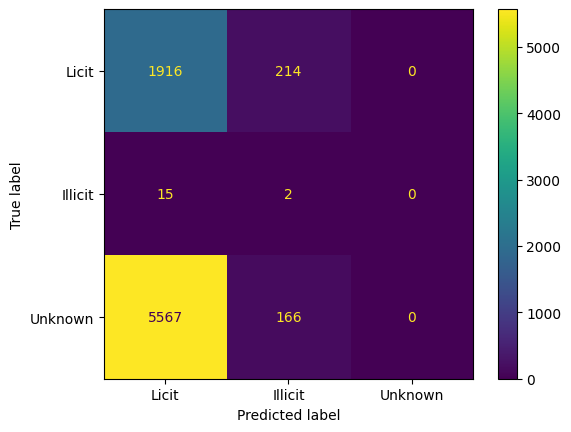

In [ ]:
real_values = data.y.numpy()
predictions = pred.numpy()

cm = confusion_matrix(real_values, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Licit', 'Illicit', 'Unknown'])
disp.plot()
plt.show()

---
## **AnomalyDAE**

In [ ]:
from pygod.detector import AnomalyDAE

dominant_detector = AnomalyDAE(contamination=0.05)
dominant_detector.fit(data)

AnomalyDAE(act=<function relu at 0x7c3b8cf9ab90>, alpha=0.5, backbone=None,
           batch_size=7880, compile_model=False, contamination=0.05,
           dropout=0.0, emb_dim=64, epoch=5, eta=1.0, gpu=None, hid_dim=64,
           lr=0.004, num_layers=4, num_neigh=[-1, -1, -1, -1],
           save_emb=False, theta=1.0, verbose=0, weight_decay=0.0)

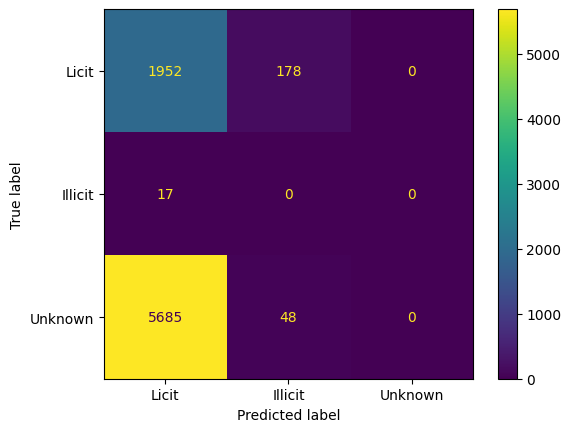

In [ ]:
pred = dominant_detector.predict(data,
                                 return_pred=True,
                                 return_score=False,
                                 return_prob=False,
                                 return_conf=False)

real_values = data.y.numpy()
predictions = pred.numpy()

cm = confusion_matrix(real_values, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Licit', 'Illicit', 'Unknown'])
disp.plot()
plt.show()

---
---

&nbsp;
&nbsp;
&nbsp;

# Pruebas 2
---

## 1. **Preparación**

In [1]:
#@title ### Instalación de librerías

import torch

!pip install torch_geometric

# Optional dependencies:
if torch.cuda.is_available():
    !pip install pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.2.0+cu121.html
else:
    !pip install pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-2.2.0+cpu.html

Looking in links: https://data.pyg.org/whl/torch-2.2.0+cpu.html


In [2]:
#@title ### Montar la Unidad de Drive
from google.colab import drive
from os import path as osp

drive.mount('/content/gdrive',force_remount=True)
%cd '/content/gdrive/My Drive/Colab Notebooks/TFG Infor'

Mounted at /content/gdrive
/content/gdrive/My Drive/Colab Notebooks/TFG Infor


##2. **Obtención de datos**


### Creación de dataframes de Pandas a partir de los CSVs

In [3]:
import pandas as pd
import numpy as np

df_features = pd.read_csv("./Datasets/Elliptic Bitcoin Dataset/elliptic_txs_features.csv", header=None)
df_classes = pd.read_csv("./Datasets/Elliptic Bitcoin Dataset/elliptic_txs_classes.csv")
df_edgelist = pd.read_csv("./Datasets/Elliptic Bitcoin Dataset/elliptic_txs_edgelist.csv")

class_mapping = {
    '1': 1,
    '2': 0,
    'unknown': 2
}

df_classes['class'] = df_classes['class'].map(class_mapping)
df_transactions = pd.merge(df_classes, df_features, left_on='txId', right_on=df_features.columns[0], how='inner').drop(df_features.columns[0], axis=1)
df_transactions.columns.values[2] = 'timestep'

In [4]:
df_transactions

,txId,class,timestep,2,3,4,5,6,7,8,...,157,158,159,160,161,162,163,164,165,166
0,230425980,2,1,-0.171469,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,...,-0.562153,-0.600999,1.461330,1.461369,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
1,5530458,2,1,-0.171484,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,...,0.947382,0.673103,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
2,232022460,2,1,-0.172107,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,...,0.670883,0.439728,-0.979074,-0.978556,-0.098889,-0.106715,-0.131155,-0.183671,-0.120613,-0.119792
3,232438397,0,1,0.163054,1.963790,-0.646376,12.409294,-0.063725,9.782742,12.414558,...,-0.577099,-0.613614,0.241128,0.241406,1.072793,0.085530,-0.131155,0.677799,-0.120613,-0.119792
4,230460314,2,1,1.011523,-0.081127,-1.201369,1.153668,0.333276,1.312656,-0.061584,...,-0.511871,-0.400422,0.517257,0.579382,0.018279,0.277775,0.326394,1.293750,0.178136,0.179117
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203764,173077460,2,49,-0.145771,-0.163752,0.463609,-0.121970,-0.043875,-0.113002,-0.061584,...,-0.577099,-0.613614,0.241128,0.241406,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
203765,158577750,2,49,-0.165920,-0.123607,1.018602,-0.121970,-0.043875,-0.113002,-0.061584,...,0.162722,0.010822,1.461330,1.461369,-0.098889,-0.087490,-0.084674,-0.140597,-1.760926,-1.760984
203766,158375402,1,49,-0.172014,-0.078182,1.018602,0.028105,-0.043875,0.054722,-0.061584,...,1.261246,1.985050,1.461330,1.461369,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
203767,158654197,2,49,-0.172842,-0.176622,1.018602,-0.121970,-0.043875,-0.113002,-0.061584,...,-0.397749,-0.411776,1.461330,1.461369,-0.098889,-0.087490,-0.084674,-0.140597,1.519700,1.521399


In [5]:
df_edgelist

,txId1,txId2
0,230425980,5530458
1,232022460,232438397
2,230460314,230459870
3,230333930,230595899
4,232013274,232029206
...,...,...
234350,158365409,157930723
234351,188708874,188708879
234352,157659064,157659046
234353,87414554,106877725


### Construcción de *Dataset* de *PyG*

In [6]:
def get_masked_edges(masked_df_tx):
    tnx_mapping = {tnx: idx for idx, tnx in enumerate(masked_df_tx['txId'].values)}

    masked_df_edgelist = df_edgelist[df_edgelist['txId1'].isin(masked_df_tx['txId']) & df_edgelist['txId2'].isin(masked_df_tx['txId'])]
    masked_df_edgelist_byIdx = pd.DataFrame()
    masked_df_edgelist_byIdx['source'] = masked_df_edgelist['txId1'].map(tnx_mapping)
    masked_df_edgelist_byIdx['dest'] = masked_df_edgelist['txId2'].map(tnx_mapping)

    return masked_df_edgelist_byIdx

In [7]:
import numpy as np
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from tqdm.notebook import tqdm

dataset = dict()

for t in tqdm(range(1, 50)):
    dataset[t] = Data()

    masked_df_tnx = df_transactions[df_transactions['timestep'] == t].reset_index(drop=True)

    dataset[t].x = torch.tensor(df_transactions.iloc[:, 3:].values).float()
    dataset[t].y = torch.tensor(df_transactions.iloc[:,1].values).float()
    labelled_mask = (masked_df_tnx['class'] == 0) | (masked_df_tnx['class'] == 1)
    dataset[t].train_mask = torch.tensor(labelled_mask.values)
    dataset[t].test_mask = torch.tensor(labelled_mask.values)

    masked_edgelist = get_masked_edges(masked_df_tnx)
    dataset[t].edge_index = torch.from_numpy(masked_edgelist.values).t().contiguous()

    try:
        dataset[t].validate()
    except ValueError as err:
        print(f'Fallo en el timestep {t}')
        print(err)
        raise


  0%|          | 0/49 [00:00<?, ?it/s]

## 3. ***Structure Autoencoder***

In [8]:
from torch.nn import BatchNorm1d
import torch.nn.functional as F
from torch_geometric.nn.models import GAE, GAT

encoder = GAT(in_channels=165,
              hidden_channels=64,
              num_layers=2,
              v2=True,
              dropout=0.2,
              act=F.leaky_relu,
              norm="batch_norm",
              )

gae = GAE(encoder)  # El decoder por defecto es InnerProductDecoder

In [9]:
batch_size=2
lr = 0.005
wd = 0.001
num_epochs = 50
data_loader = DataLoader([dataset[t] for t in range(1,50)], batch_size=batch_size)
optimizer = torch.optim.Adam(gae.parameters(), lr=lr, weight_decay=wd)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


def train():
    global gae, optimizer, data_loader

    total_loss = 0
    gae.train()
    for i, batch in enumerate(data_loader):
        optimizer.zero_grad()

        batch = batch.to(device)
        emb = gae(batch.x, batch.edge_index)

        loss = gae.recon_loss(emb, batch.edge_index)
        total_loss += loss
        loss.backward()
        optimizer.step()

    return total_loss

gae.reset_parameters()
gae = gae.to(device)
for e in tqdm(range(num_epochs)):
    loss = train()
    print(f'Epoch {(e+1):03d}/{num_epochs} | Total loss: {loss:.6f}')

  0%|          | 0/50 [00:00<?, ?it/s]

Epoch 001/50 | Total loss: 42.671318
Epoch 002/50 | Total loss: 26.928589
Epoch 003/50 | Total loss: 24.520664
Epoch 004/50 | Total loss: 23.930792
Epoch 005/50 | Total loss: 23.195147
Epoch 006/50 | Total loss: 22.627068
Epoch 007/50 | Total loss: 22.283587
Epoch 008/50 | Total loss: 24.087584
Epoch 009/50 | Total loss: 22.742111
Epoch 010/50 | Total loss: 22.147078


KeyboardInterrupt: 

<generator object Module.parameters at 0x79fd83920270>


In [ ]:
import torch
from torch_geometric.nn import HGTConv, Linear

class HGT_BinaryClassifier(torch.nn.Module):

    def __init__(self, embedding_dim, num_layers, backend='GCN', **kwargs):
        super().__init__()

        _possible_backends = ['GCN', 'GAT']
        if not backend in _possible_backends:
            print(f'Possible backends are: {_possible_backends}')
            raise

        self.layers
        for i in range(num_layers):
            self.layer

        self.in_lin_dict = ModuleDict()
        self.out_lin_dict = ModuleDict()
        self.l = LeakyReLU()
        for node_type in self.metadata[0]:   # Node types
            self.in_lin_dict[node_type] = Linear(-1, embedding_dim)
            self.out_lin_dict[node_type] = Linear(embedding_dim, 1)

        self.convs = torch.nn.ModuleList()
        for _ in range(num_layers):
            conv = HGTConv(embedding_dim, embedding_dim, self.metadata,
                           num_heads)
            self.convs.append(conv)


    def forward(self, x_dict, edge_index_dict):
        """
        Primero se aplica una transformación lineal seguida de la función de
        activación LeakyReLU para cada tipo de nodo, con el objetivo de que
        todos los tipos trabajen en las mismas dimensiones.
        """
        x_dict = {
            node_type: self.l(self.in_lin_dict[node_type](x))
            for node_type, x in x_dict.items()
        }

        """
        Se aplican todas las capas convolucionales del modelo HGT
        """
        for conv in self.convs:
            x_dict = conv(x_dict, edge_index_dict)
            x_dict = {
                node_type: self.l(x_dict[node_type])
                for node_type in x_dict.keys()
            }


        """
        Se aplica una última transformación lineal para obtener un único
        valor (Logit) de salida.
        """
        x_dict = {
            node_type: self.out_lin_dict[node_type](x).t()[0]
            for node_type, x in x_dict.items()
        }

        return x_dict

    def reset_parameters(self):
        for node_type in self.metadata[0]:
            self.in_lin_dict[node_type].reset_parameters()
            self.out_lin_dict[node_type].reset_parameters()

        for conv in self.convs:
            conv.reset_parameters()
